# L-band Radar Transmitter Leakage Cancellation

The goal is to canncel the internal and external leakage from the signal of interest(SOI). Because software defined radio record the downconverted received signal directly from attenna without dechirp or comparing to the reference signal, so it is not feaseble to prevent ADC saturation by adding a gating filter such as a high-pass filter or a DC blocker. The strong coupled signal will saturates the ADC if the SOI is reletivly small, it will not be well detected due to limited ADC resolution and dynamic range.For example, B200mini ADC has 12 bit which gives the dynamic range: 

\begin{equation*}
 SNR_{max} = 1.76+6.02 \times 12= 74dB. 
\end{equation*}


If the transmitted signal strength is 30dBm, and the tx-rx antenna isolation is 50dB which could be the best case senario, then the received leakage signal is -20dBm at LNA. If the LNA has 20dB gain, and ignore the down convertion mixer loss, the minimum power can be detected at ADC is 30dBm -50dB + 20dB - 74dB = -74dBm. However, if the transmit leakage can be made less severe, the theoretical minimum power can be detected at ADC could be lower, for example, 30dBm -100dB +20dB - 74dB = -124dBm.<br>
The point here is that if there is strong leakage signal, then noise floor is determined by it but not the thermal noise, and this could affect the sensitivity of the radar system. By increasing the amplifier's gain in the receving chain could help detecting small variation of the siganl of interest. But if the changes of the SOI is very small, it is necessary to reduce the leakage to fully use the dynamic range of ADC. Hence, cancellation of the strong tx-rx leakage becomes important.

It is a well known problem in communication domain that people would like to have full duplex transceiver which means transmitting and receiving at the same time. So it is possible to use the exsited solutions to canncel unwanted leakage signal. One method is that estimate the transmite leakage channel in which there are internal, external leakage signals, and near-range strong reflections. By using a transmit template signal as input signal and the estimated leakage channel, the cancellation signal can be calculated. The leakage channel is just a summation of delayed and weigted version of the transmit template input signal, and the channel dimension determines the how far the leakage channel range covers. After getting the cancellation signal, substract it from the originial received singal and feed it to the receiver before LNA. It is possible to use analytical method to obtian the leakage channel because the template signal is known and the size of it could be not too large. There are other methods to get channel matrix such as LMS algorithm.

Let's do a simulation first. The transmitted template input singal at base band: 
\begin{equation}
x_{i} = cos(2\pi (f_0 t + 0.5K t^2))
\end{equation}
where K is the chirp rate.

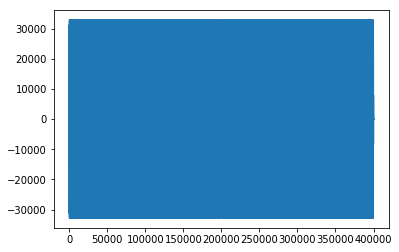

In [13]:
import numpy as np
import matplotlib.pyplot as plt
#############
#Parameters
#############
c = 3e8
j = 1j
fs = 56e6  # Sampling freq
N = 400000  # This also limit the bandwidth. And this is determined by fpga LUT size.
T = N/fs  # T=N/fs#Chirp Duration
t = np.linspace(0, T, N)
f0 = -28e6  # Start Freq
f1 = 28e6  # fs/2=1/2*N/T#End freq
K = (f1 - f0) / T # chirp rate = BW/Druation
phi0 = (4999+1) * np.pi / 10000  # Phase
f = np.linspace(0, fs-1, N)
freq = np.fft.fftfreq(N, d=1 / fs)
distance = c * freq / K / 2.0
win=1
##################
# Create the chirp
##################
x0 = 1*np.sin(2 * np.pi * (f0 * t + K / 2 * np.power(t, 2)))  # use this for chirp generation
xq0 = 1*np.sin(phi0 + 2 * np.pi * (f0 * t + K / 2 * np.power(t, 2)))  # use this for chirp generation
x = np.around(np.power(2,15)*np.multiply(x0, win))
xq = np.around(np.power(2,15)*np.multiply(xq0, win))
x_cx = x + j * xq
plt.figure(1)
plt.plot(np.real(x_cx))


If using the transmeted signal as a template, adding the delayed versions to it. Assuming the received singal is the summation of the leakage and SOI. After pulse compression by Stretching Method. The range information can be extracted.

Text(0,0.5,'Power in dB')

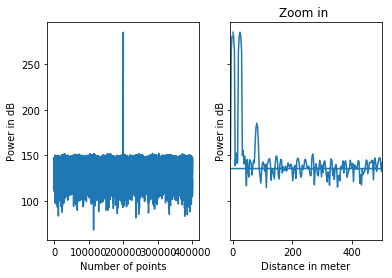

In [14]:
y_cx_delay_1 = np.concatenate((np.zeros(9), x_cx[:N-9]), axis=0)
y_cx_delay_2 = np.concatenate((np.zeros(100), x_cx[:N-100]), axis=0)
y_cx_delay_3 = np.concatenate((np.zeros(30), x_cx[:N-30]), axis=0)
y_cx_received = 1 * x_cx + 1*y_cx_delay_1 + 1e-7*y_cx_delay_2 + 1e-5*y_cx_delay_3 

######################################
# Pulse Compression Stretching Method
#####################################
def PulseCompr(rx,tx,win):
    A = np.multiply(rx,win) # Add window here
    B = tx
    PC = 20*np.log10(abs(np.fft.fft(A*np.conj(B))))
    return PC

PC = PulseCompr(y_cx_received,x_cx,np.blackman(N))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(np.fft.fftshift(PC))
ax1.set_xlabel('Number of points')
ax1.set_ylabel('Power in dB')
ax2.plot(distance,PC)
ax2.set_title('Zoom in ')
ax2.set_xlim((-10,500))
ax2.set_xlabel('Distance in meter')
ax2.set_ylabel('Power in dB')


The  cancellation signal 
\begin{equation}
x_{canc} = U[m]w[m]
\end{equation}
The best weight matrix can be calculated as 
\begin{equation}
w[m] = R^{-1}_uR_{du}
\end{equation}
Covariance Matrix is 
\begin{equation}
R_u = E[U^HU]=U^HU
\end{equation}
Cross-covariance matrix of {d,U} is 
\begin{equation}
R_{du} = E[U^Hd]=U^Hd
\end{equation}
where d is a scalor.



Now, we need to find the cancellation signal. Here is an example for channel estimation, estimating channel {c(i)} with input sequence {s(i)} (this is given), additive noise {v(i)} and available measurements are {y(i)}.
\begin{equation}
\left[
\begin{matrix} 
    y(0)\\
    y(1)\\
    y(2)\\
    y(3)\\
    y(4)\\
    y(5)\\
    y(6)\\
\end{matrix}
\right]
=\underbrace{\left[
\begin{matrix} 
    x(0)\\
    x(1) & x(0)\\
    x(2) & x(1) & x(0)\\
    x(3) & x(2) & x(1)\\
    x(4) & x(3) & x(2)\\
    x(5) & x(4) & x(3)\\
    x(6) & x(5) & x(4)\\
\end{matrix}
\right]}_\text{H:(N+1)$\times$M}
\left[
\begin{matrix} 
    c(0)\\
    c(1)\\
    c(2)\\
\end{matrix}
\right]
+\left[
\begin{matrix} 
    v(0)\\
    v(1)\\
    v(2)\\
    v(3)\\
    v(4)\\
    v(5)\\
    v(6)\\
\end{matrix}
\right]
= c0\left[
\begin{matrix} 
    x(0)\\
    x(1)\\
    x(2)\\
    x(3)\\
    x(4)\\
    x(5)\\
    x(6)\\
\end{matrix}
\right]
+c1\left[
\begin{matrix} 
    0\\
    x(0)\\
    x(1)\\
    x(2)\\
    x(3)\\
    x(4)\\
    x(5)\\
\end{matrix}
\right]
+c2\left[
\begin{matrix} 
    0\\
    0\\
    x(0)\\
    x(1)\\
    x(2)\\
    x(3)\\
    x(4)\\
\end{matrix}
\right]
+\left[
\begin{matrix} 
    v(0)\\
    v(1)\\
    v(2)\\
    v(3)\\
    v(4)\\
    v(5)\\
    v(6)\\
\end{matrix}
\right]
\end{equation}


The matrix H dimonsion, M, determines how far the cancel signal covering because matrix H is a summation of delayed transmit signal. The calculated channel should be in the covering range.<br>
The column vector is the channel which can be obtained if H and y are given. 
\begin{equation}
c = R_H^{-1}R_{yH}=(H^HH)^{-1}H^Hy=w
\end{equation}

In [15]:
def channel_est(psi_orth, y_cx_received):
    # Calculate weights
    # 1. Make H matrix
    psi_orth_delay_0 = np.concatenate((np.zeros(0), psi_orth[:N-0]), axis=0)
    psi_orth_delay_1 = np.concatenate((np.zeros(1), psi_orth[:N-1]), axis=0)
    psi_orth_delay_2 = np.concatenate((np.zeros(2), psi_orth[:N-2]), axis=0)
    psi_orth_delay_3 = np.concatenate((np.zeros(3), psi_orth[:N-3]), axis=0)
    psi_orth_delay_4 = np.concatenate((np.zeros(4), psi_orth[:N-4]), axis=0)
    psi_orth_delay_5 = np.concatenate((np.zeros(5), psi_orth[:N-5]), axis=0)
    psi_orth_delay_6 = np.concatenate((np.zeros(6), psi_orth[:N-6]), axis=0)
    psi_orth_delay_7 = np.concatenate((np.zeros(7), psi_orth[:N-7]), axis=0)
    psi_orth_delay_8 = np.concatenate((np.zeros(8), psi_orth[:N-8]), axis=0)
    psi_orth_delay_9 = np.concatenate((np.zeros(9), psi_orth[:N-9]), axis=0)
    H= np.transpose([psi_orth_delay_0,psi_orth_delay_1,psi_orth_delay_2,psi_orth_delay_3,psi_orth_delay_4,psi_orth_delay_5,
        psi_orth_delay_6,psi_orth_delay_7,psi_orth_delay_8,psi_orth_delay_9])
    print('Shape of H is',H.shape)

    # 2. Make y vector
    y = np.transpose(y_cx_received[np.newaxis])
    print('Shape of y is', y.shape)

    # 3. Calculate channel
    R_H = np.dot(np.matrix.getH(H),H) # Covariance Matrix of H
    print('Shape of R_H is', R_H.shape)
    R_yH = np.dot(np.matrix.getH(H),y)# Cross-covariance Matrix of {y,H}
    print('Shape of R_yH is', R_yH.shape)
    c = np.dot(np.linalg.inv(R_H),R_yH)
    print('Shape of c is', c.shape)
    return c, H


# For test, this skips the orthognalization!
w, H = channel_est(psi_orth = x_cx, y_cx_received = y_cx_received)

Shape of H is (400000, 10)
Shape of y is (400000, 1)
Shape of R_H is (10, 10)
Shape of R_yH is (10, 1)
Shape of c is (10, 1)


The  cancellation signal 
\begin{equation}
x_{canc} = Hw
\end{equation}
The final signal before receiver's LNA is 
\begin{equation}
y_{canc} = y - x_{canc}
\end{equation}

Text(0,0.5,'Power in dB')

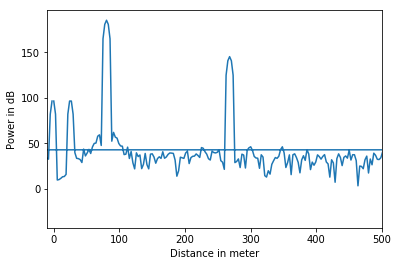

In [16]:
x_canc = np.squeeze(np.dot(H,w)) # np.squeeze is make shape of x_canc same for later calculation
y_canc = y_cx_received - x_canc.T
PC = PulseCompr(rx=y_canc,tx=x_cx,win=np.blackman(N))
plt.plot(distance,PC)
plt.xlim((-10,500))
plt.xlabel('Distance in meter')
plt.ylabel('Power in dB')

The leakage is within 10 taps or delays, the corresponing distance is equal to 
\begin{equation}
distance = \frac{cf}{2K}=26.8 meter
\end{equation}
where K is chirp rate, K = fs / tc, f = 10(fs/N).<br>
In the above figure, the leakage is alleviated and two small point targets in far range become visible. 

Up to this point, we are using given template signal as transmitted signal, however, this signal is an ideal signal which must be distorted by active and passive RF components in the transmission chain. It is important to know that the real transmitted signal after the antenna must be changed by those RF components, for example, power amplifier could add third-order and higher order harmonic tones, transmission lines have more attenuation at higher frequency. Let's use the real measured signal, a loopback chirp signal without antennas.

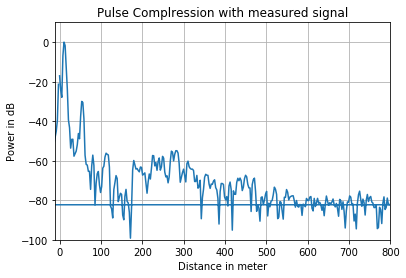

In [17]:
import os
import scipy.io as sio
###################
# Import Signals
###################
# Transmited signal 
#tx_data = sio.loadmat('refsig_B200_08142018_avg50_400000points_anttena.mat') #a loopback chirp signal with antennas.
tx_data = sio.loadmat('refsig_B200_08142018_avg100_400000points_realsig.mat') # a loopback chirp signal without antennas.
#tx_data = sio.loadmat('refsig_B200_08142018_avg20_400000points.mat') # a loopback chirp signal before external PA just b200mini 
tx_sig = np.squeeze(tx_data['refsig_avg'])
# Received signal
rx_sum = np.zeros(N)
#fileID = open("usrp_samples_loopback_08222018_large_reflector_60m.dat", "rb")  # reopen the file
fileID = open("usrp_samples_loopback_08222018_further_44meterreflextor_1meter.dat", "rb")  # reopen the file
pulse_to_avg = 200
offset = 4*N
for m in range(0,pulse_to_avg):
    fileID.seek(offset*m, os.SEEK_SET)  # seek
    data_rx = np.fromfile(fileID, np.short, 2*N)  # read the data into numpy
    imag = data_rx[::2]
    real = data_rx[1::2]
    rx = (real+j*imag)/32767
    rx_sum = rx_sum+rx

rx_avg = rx_sum/pulse_to_avg
#plt.plot(np.real(rx_avg))
#plt.show()

PC = PulseCompr(rx = rx_avg,tx = tx_sig,win = np.blackman(N))

plt.figure()
plt.plot(distance,PC -np.max(PC))
plt.xlim((-10,800))
plt.ylim((-100,10))
plt.xlabel('Distance in meter')
plt.ylabel('Power in dB')
plt.title('Pulse Complression with measured signal')
plt.grid()
plt.show()

A template signal is recorded by adding a loopback transmission line and attenuator between transmitter and receiver ports. Use this template signal as input signal. The received signal is the real measured signal by radar system in field. The measurement was taken on Augest 22, 2018, a reflector was placed 44 meters away from radar, the phisical seperation distance between tx and rx-attenna was about 3 meters which not including cable distance. In the figure, a strongest peak is the leakage signal. And the second peak at about 44 meters is the conner reflector.

Shape of H is (400000, 10)
Shape of y is (400000, 1)
Shape of R_H is (10, 10)
Shape of R_yH is (10, 1)
Shape of c is (10, 1)


/home/james/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


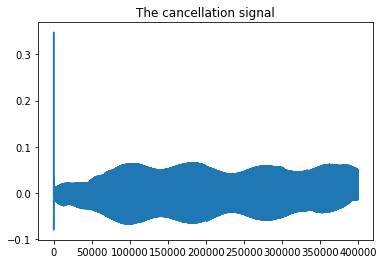

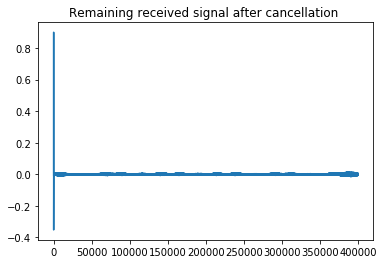

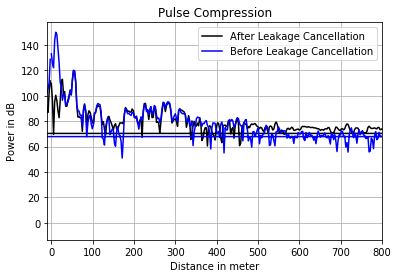

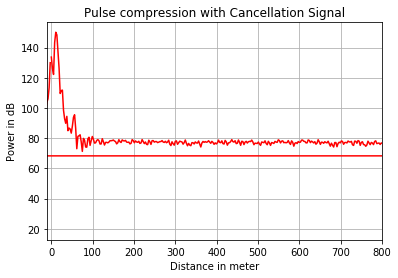

In [18]:
w,H = channel_est(psi_orth = tx_sig, y_cx_received = rx_avg)
x_canc = np.squeeze(np.dot(H,w)) # np.squeeze is make shape of x_canc same for later calculation
plt.plot(x_canc)
plt.title('The cancellation signal')
y_canc = rx_avg - x_canc.T
plt.figure()
plt.plot(y_canc)
plt.title('Remaining received signal after cancellation ')
# Pulse compression after cancellation
PC = PulseCompr(rx=y_canc,tx=tx_sig,win=np.blackman(N))
plt.figure()
plt.plot(distance,PC,'k',label='After Leakage Cancellation')
plt.xlim((-10,800))
plt.xlabel('Distance in meter')
plt.ylabel('Power in dB')
plt.grid()
# Pulse compression before cancellation
PC = PulseCompr(rx = rx_avg,tx = tx_sig,win = np.blackman(N))
plt.plot(distance,PC,'b',label='Before Leakage Cancellation')
plt.title('Pulse Compression')
plt.legend()

# Pulse compression with just cancellation signal
PC = PulseCompr(rx = x_canc.T,tx=tx_sig,win=np.blackman(N))
plt.figure()
plt.plot(distance,PC,'r')
plt.xlim((-10,800))
plt.xlabel('Distance in meter')
plt.ylabel('Power in dB')
plt.title('Pulse compression with Cancellation Signal')
plt.grid()
plt.show()

In the third plot above, there is about 150 - 100 = 50 dB cancellation for the tx-rx attenna leakage. It can be seen that the targets at further range are remained. The behavior of this method is similar as low-pass-filtering out all the unwanted signal. <br>
Not that the remainning signal SNR is not changed here because this cancellation was done after ADC. The signal contained the strong leakage signal was recorded by ADC, so the noise floor was fixed by ADC dynamic range and the strongest signal, the leakage, which is as a reference of maximum dynamic range level. But if cancellation is done before ADC and LNA, the residual signal $y_{canc}$ can be further amplified by LNA in RF front end, then the ADC dynamic range can be fullfilled only for SOI, and hence the SNR can be improved. Note that this method should work with other leakage mitigation methods such as phisically seperate transmit and receive antennas.

Some ideas: This method is based on the fact that the original baseband transmit signal $x[n]$ is known. However, the initial phase of this is random, so it may not be perfect to use a template to represent the original transmit signal. There is a "blind" method to learn U(n) instead of using given U(n).[6]<br>
The performance for calculating the channel weights could be improved by using LMS methods considering the complexity of algorithm.[6]

The next step is to use Ettus boards to generate cancellation signal and implement leakage cancellation. <br>
The best way to implement this is using C++ control, UHD + RFNoC.

References:<br>
[1] The Mahalanobis decorrelation transformation, http://www.davidsalomon.name/DC2advertis/DeCorr.pdf<br>
[2] Whitening transformation, https://en.wikipedia.org/wiki/Whitening_transformation<br>
[3] A. Kiayani et al., "Adaptive Nonlinear RF Cancellation for Improved Isolation in Simultaneous Transmit–Receive Systems," in IEEE Transactions on Microwave Theory and Techniques, vol. 66, no. 5, pp. 2299-2312, May 2018.<br>
[4] J, Zaidouni & , P.Deloof & Menhaj, Atika & Niar, Smail & Rouvaen, J.M.. (2008). Leakage Cancellation in Coded Automotive Radar. Lecture Notes in Engineering and Computer Science. 2172. <br>
[5] Ali H. Sayed. Fundamentals of adaptive filtering. Wiley-IEEE Press, 2003.<br>
[6] Chang, John. Microwave Photonic Filters for Interference Cancellation and Adaptive Beamforming, 2014, http://arks.princeton.edu/ark:/88435/dsp012514nk64r <br>

In [12]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
''')